In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Numerical Solution to ODE Initial Value Problems

Many physical, biological, and societal systems can be written as a system of ordinary differential equations (ODEs).  In the case where the initial state (value) is know the problems can be written as

$$\frac{\text{d} \vec{u}}{\text{d}t} = \vec{f}(t, \vec{u}) ~~~~ \vec{u}(0) = \vec{u}_0$$

where
 - $\vec{u}(t)$ is the state vector
 - $\vec{f}(t, \vec{u})$ is a vector-valued function that controls the growth of $\vec{u}$ with time
 - $\vec{u}(0)$ is the initial condition at time $t = 0$

#### Examples:  Simple radioactive decay
$\vec{u} = [c]$
   
$$\frac{\text{d} c}{\text{d}t} = -\lambda c ~~~~ c(0) = c_0$$
   

which has solutions of the form $c(t) = c_0 e^{-\lambda t}$

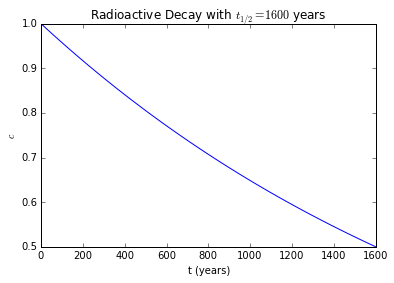

In [2]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, 1.0 * numpy.exp(-decay_constant * t))

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_ylim((0.5,1.0))
plt.show()

#### Examples:  Complex radioactive decay (or chemical system).

Chain of decays from one species to another.

$$\begin{aligned}
    \frac{\text{d} c_1}{\text{d}t} &= -\lambda_1 c_1 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_1 c_1 - \lambda_2 c_2 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_2 c_3 - \lambda_3 c_3 
\end{aligned}$$

$$\frac{\text{d} \vec{u}}{\text{d}t} = \frac{\text{d}}{\text{d}t}\begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix} = 
\begin{bmatrix} 
    -\lambda_1 & 0 & 0 \\
    \lambda_1 & -\lambda_2 & 0 \\
    0 & \lambda_2 & -\lambda_3
\end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix}$$

$$\frac{\text{d} \vec{u}}{\text{d}t} = A \vec{u}$$

For systems of equations like this the general solution to the ODE is the matrix exponential:

$$\vec{u}(t) = \vec{u}_0 e^{A t}$$

#### Examples: Van der Pol Oscillator

$$y'' - \mu (1 - y^2) y' + y = 0~~~~~\text{with}~~~~ y(0) = y_0, ~~~y'(0) = v_0$$
 
$$\vec{u} = \begin{bmatrix} y \\ y' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$
   
$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} u_2 \\ \mu (1 - u_1^2) u_2 - u_1 \end{bmatrix} = \vec{f}(t, \vec{u})$$

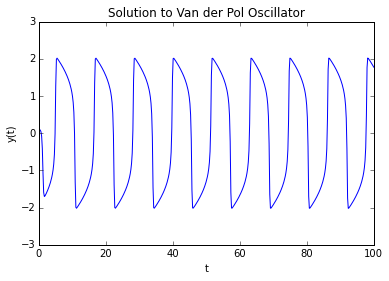

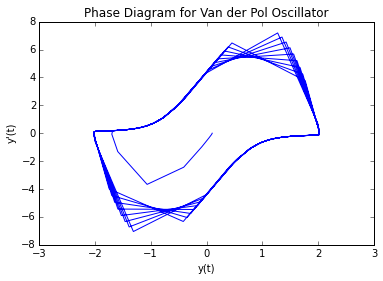

In [3]:
import scipy.integrate as integrate

def f(t, u, mu=5):
    return numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])

t = numpy.linspace(0.0, 100, 500)
u = numpy.empty((2, 500))
u[:, 0] = [0.1, 0.0]

integrator = integrate.ode(f)
integrator.set_integrator("dopri5")
integrator.set_initial_value(u[:, 0])

for (n, t_n) in enumerate(t[1:]):
    integrator.integrate(t_n)
    if not integrator.successful():
        break
    u[:, n + 1] = integrator.y
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, u[0,:])
axes.set_title("Solution to Van der Pol Oscillator")
axes.set_xlabel("t")
axes.set_ylabel("y(t)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(u[0,:], u[1, :])
axes.set_title("Phase Diagram for Van der Pol Oscillator")
axes.set_xlabel("y(t)")
axes.set_ylabel("y'(t)")

plt.show()

#### Examples:  Particle tracking in a fluid

$$\frac{\text{d} \vec{X}}{\text{d}t} = \vec{V}(t, \vec{X})$$

In fact all ODE IVP systems can be thought of as tracking particles through a flow field (dynamical system).  In 1-dimension the flow "manifold" we are on is fixed by the initial condition.

## Basic Stepping Schemes

Looking back at our work on numerical differentiation why not approximate the derivative as a finite difference:

$\frac{u(t + \Delta t) - u(t)}{\Delta t} = f(t, u)$

We still need to decide how to evaluate the $f(t, u)$ term however.  Lets look at this from a perspective of quadrature, take the intergral of both sides:

$\begin{aligned}\int^{t + \Delta t}_t \frac{\text{d} u}{\text{d}\tilde{t}} d\tilde{t} &= \int^{t + \Delta t}_t f(t, u) d\tilde{t} \\
u(t + \Delta t) - u(t) &= \Delta t f(t, u(t))
\frac{u(t + \Delta t) - u(t)}{\Delta t} &= f(t, u(t))
\end{aligned}$

where we have used a left-sided quadrature rule for the integral on the right.  Introducing some notation to simpify things

$t_0 = 0$
$t_1 = t_0 + \Delta t$
$t_n = t_{n-1} + \Delta t = n \Delta t + t_0$

$u_0 = u(t_0)$
$u_1 = u(t_1)$
$u_n = u(t_n)$

we can rewrite our scheme as

$\frac{u_{n+1} - u_n}{\Delta t} = f(t_n, u_n)$

or

$u_{n+1} = u_n + \Delta t f(t_n, u_n)$

which is known as the *forward Euler method*.  In essence we are approximating the derivative with the value of the function at the point we are at $t_n$.

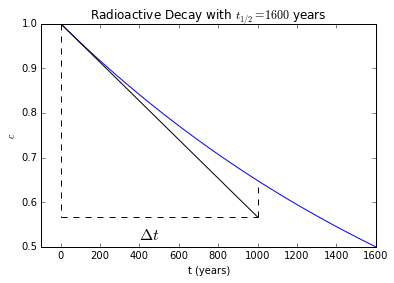

In [4]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Euler step
dt = 1e3
u_np = c_0 + dt * (-decay_constant * c_0)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

A similar method can be derived if we consider instead using the mid-point rule for the quadrature:

$$u_{n+1} - u_{n-1} = 2\Delta t f(t_{n}, u_{n})$$

this method is known as either the mid-point method or more commonly as the leap-frog method.  Note that the way we have written this method requires a previous function evaluation and technically is a "multi-step" method although we do not actually use the current evaluation.

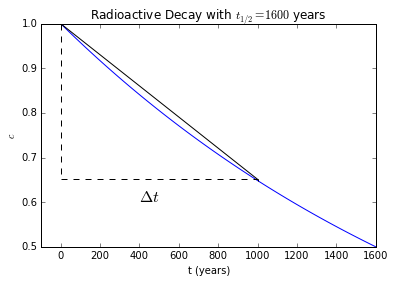

In [5]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Euler step
dt = 1e3
u_np = c_0 + dt * (-decay_constant * c_0 * numpy.exp(-decay_constant * dt / 2.0))
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

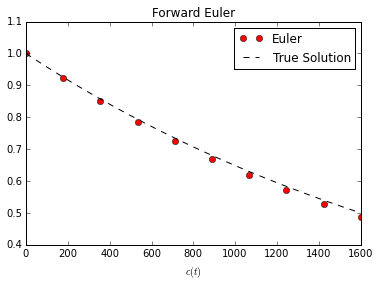

In [6]:
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement Euler
t_euler = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t_euler[1] - t_euler[0]
u_euler = numpy.empty(t_euler.shape)
u_euler[0] = c_0
for (n, t_n) in enumerate(t_euler[:-1]):
    u_euler[n + 1] = u_euler[n] + delta_t * f(t_n, u_euler[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_euler, u_euler, 'or', label="Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Forward Euler")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

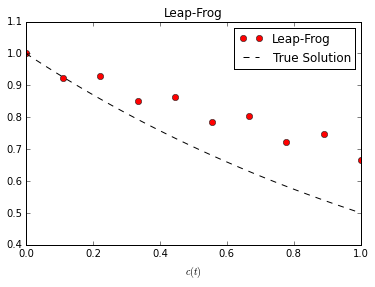

In [7]:
c_0 = 1.0
# decay_constant = numpy.log(2.0) / 1600.0
decay_constant = numpy.log(2.0)
f = lambda t, u: -decay_constant * u

# t_exact = numpy.linspace(0.0, 1.6e3, 100)
t_exact = numpy.linspace(0.0, 1.0, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement leap-frog
# t_leapfrog = numpy.linspace(0.0, 1.6e3, 10)
t_leapfrog = numpy.linspace(0.0, 1.0, 10)
delta_t = t_leapfrog[1] - t_leapfrog[0]
u_leapfrog = numpy.empty(t_leapfrog.shape)
u_leapfrog[0] = c_0
# First evaluation use Euler to get us going
u_leapfrog[1] = u_leapfrog[0] + delta_t * f(t_leapfrog[0], u_euler[0])
for (n, t_n) in enumerate(t_leapfrog[1:]):
    u_leapfrog[n + 1] = u_leapfrog[n - 1] + delta_t * f(t_n, u_leapfrog[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_leapfrog, u_leapfrog, 'or', label="Leap-Frog")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Leap-Frog")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

## Error Analysis of ODE Methods

At this point it is also helpful to introduce more notation to distinguish between the true solution to the ODE $u(t_n)$ and the approximated value which we will denote $U_n$.

**Definition:** We define the *truncation error* of a scheme by

$$T(t, u; \Delta t) = \frac{1}{\Delta t} [U_{n+1} - u(t + \Delta t)]$$

**Definition:** A method is called *consistent* if $\lim_{\Delta t \rightarrow 0} T(t, u; \Delta t) = 0$.

**Definition:** We say that a method is *order* $p$ accurate if

$$||T(t, u; \Delta t) || \leq C \Delta t^p$$

uniformally on $t \in [0, T]$.  This can also be written as $T(t, u; \Delta t) = \mathcal{O}(\Delta t^p)$.  Note that a method is consistent if $p > 0$.

### Error Analysis of Forward Euler

We can analyze the error and convergence order of forward Euler by considering the Taylor series centered at $t_n$:

$u(t) = u(t_n) + (t - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3)$

Evaluating this series at $t_{n+1}$ gives

$\begin{aligned}
u(t_{n+1}) &= u(t_n) + (t_{n+1} - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t_{n+1} - t_n)^2 + \mathcal{O}((t_{n+1}-t_n)^3)\\
&=u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{aligned}$

From the definition of truncation error we can use our Taylor series expression and find the truncation error to be

$\begin{aligned}
T(t, u; \Delta t) &= \frac{1}{\Delta t} [U_{n+1} - u(t + \Delta t)] \\
&= \frac{1}{\Delta t} \left[ u_n + \Delta t f(t_n, u_n) - \left( u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right )\right ] \\
&= \frac{1}{\Delta t} \left[ - \frac{u''(t_n)}{2} \Delta t^2 - \mathcal{O}(\Delta t^3) \right ] \\
&= - \frac{u''(t_n)}{2} \Delta t - \mathcal{O}(\Delta t^2)
\end{aligned}$

This implies that forwar Euler is first order accurate and therefore consistent.

### Error Analysis of Leap-Frog Method

To easily analyze this method we will expand the Taylor series from before to another order and evaluate at both the needed positions:

$u(t) = u(t_n) + (t - t_n) u'(t_n) + (t - t_n)^2 \frac{u''(t_n)}{2}  + (t - t_n)^3 \frac{u'''(t_n)}{6} + \mathcal{O}((t-t_n)^4)$

leading to 

$\begin{aligned}
u(t_{n+1}) &= u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\\
u(t_{n-1}) &= u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$

Plugging this into our definition of the truncation error along with the leap-frog method definition leads to

$\begin{aligned}
T(t, u; \Delta t) &=\frac{1}{\Delta t} \left [\left(u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\right) + 2\Delta t f_n - \left(u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4) \right )\right ] \\
&=\frac{1}{\Delta t} \left [- \Delta t^3 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^4) \right ] \\
&=- \Delta t^2 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^3)
\end{aligned}$

Therefore the method is second order accurate and is consistent.


## Stability